In [1]:
%pylab inline
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


#Take Home Midterm

###David Plotz


<br>
<br>

<b>1.) We are interested in knowing if the number of defective iPhones produced by Apple on a given
day follows a Poisson distribution. In a random sample of 630 days, we get the following
summarized data.</b>

<table>
<tr><td>0</td><td>1</td><td>2</td><td>3</td><td>$\geq$4</td></tr>
<tr><td>191</td><td>228</td><td>141</td><td>51</td><td>19</td></tr>
</table>

<b>(a) Write out the appropriate hypotheses to test.</b>

$H_0$ : the number of defective iPhones produced on a given day follows a Poisson distribution.

vs.

$H_1$ : the number of defective iPhones produced on a given day follows a distribution that is not the Poisson distribution.

<b>(b) Find the MLE of λ under $H_0$.</b>

In [2]:
%%R
observed <- c(191, 228, 141, 51, 19)
n <- sum(observed)
lik <- function(lambda) {
    dmultinom(x=observed, size=n, prob=c(dpois(x=0:3, lambda=lambda), 1-ppois(q=3, lambda=lambda)))
}
mle <- optimize(f=lik, interval=c(0, 3), maximum=TRUE)
mle

$maximum
[1] 1.181387

$objective
[1] 6.476957e-06



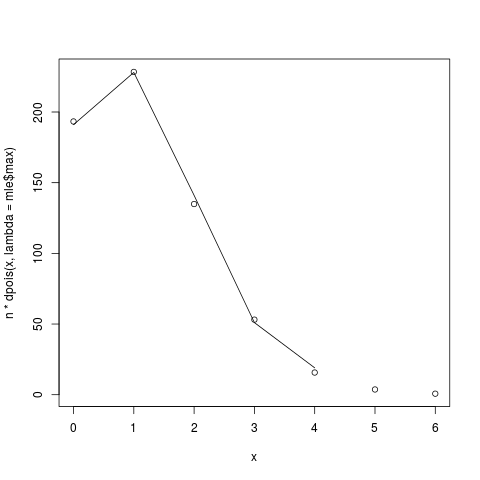

In [3]:
%%R
x <- 0:6
plot(x, n*dpois(x, lambda = mle$max))
lines(0:4, observed)

We can also try doing this in Python.

I used squared error as my cost function. I'm not sure what difference that makes...

In [4]:
from scipy.optimize import minimize
from scipy.stats import poisson

observed  = [191, 228, 141, 51, 19]
n = sum(observed)
def minimize_this(p):
    out = 0
    for i in range(len(observed)):        
        prob = n*poisson.pmf(i, p)
        if(i == len(observed)-1):
            prob = n*(1 - poisson.cdf(3, p))     
        out += (observed[i] - prob)**2    #squared error
    return out

minimize(minimize_this, 1.0)['x']

array([ 1.19515839])

With a little further thought, we can attempt to minimize the test statistic directly

In [5]:
def minimize_this(p):
    out = 0
    for i in range(len(observed)):        
        expected = n*poisson.pmf(i, p)
        if(i == len(observed)-1):
            expected = n*(1 - poisson.cdf(3, p))     
        out += observed[i]*log(observed[i]/expected)
    return out

minimize(minimize_this, 1.0)['x']

array([ 1.18138193])

<b>(c) Calculate the expected counts.</b>

In [6]:
%%R
x <- 0:3
expected <- n*c(dpois(x, lambda = mle$max), 1 - ppois(3,lambda = mle$max))
expected

[1] 193.31736 228.38254 134.90404  53.12461  20.27144


<b>(d) Calculate the appropriate test statistic and state its distribution under $H_0$.</b>

In [7]:
%%R
2*sum(observed*log(observed/expected))

[1] 0.4675273


Due to large sample theory, we know that $−2lnΛ= 0.4675$ under $H_0$ follows $\chi_3^2$. (The degrees of freedom is the number of bins, m=5, minus 1, minus the number parameters estimated (i.e. $\hat{λ}$))

<b>(e) Calculate the p−value of this test and make you conclusions.</b>

In [8]:
%%R
1 - pchisq(0.4675273, 3)

[1] 0.9259654


Wiht a p-value of 0.926, we fail to reject the null hypothesis and conclude that the fit is good.

<b>2.) A random sample of size 100 is taken from a gamma population with shape parameter 3 and
scale parameter β, having p.d.f.</b>

$$f(x) = \frac 1 {Γ(3)β^3} x^2 e^{−x/β}, ~~~~ x > 0, ~~~ β > 0$$

<b>We wish to test the null hypothesis $H_0 : β = β_0 = 5$ against the simple alternative hypothesis
$H_1 : β = β_1 > β_0$.</b>

<b>(a) Simulate 100 observations from this gamma distribution with scale β = 6. Be sure to state
the seed you are using and make the seed [set.seed()] “unusual”. Report the mean of your
simulated data.</b>

In [9]:
%%R 
set.seed(1213)
data <- rgamma(100,shape = 3, scale = 6)
mean(data)

[1] 17.1719


<b>(b) Perform the most powerful hypothesis test using this data at level α = 0.05 (do not use
the large sample approximation).</b>

We first write down the likelihood ratio:

$$\text{likelihood ratio} = \left(\frac {\beta_1}{\beta_0} \right)^{3n} \exp [- \sum X_i (\frac 1 {\beta_0} - \frac 1 {\beta_1} )]$$

We know that we will reject $H_0$ when the likelihood ratio is small, i.e., when $\sum X_i$ is big.

We are therefore are looking for a number c such that:

$$\alpha = 0.05 = \mathbb{P}(\sum X_i > c | H_0)$$

According to Wikipedia, the sum of independent gamma random variables is also distributed as gamma, but with the shape parameter summed. Therefore, our test statistic is 

In [10]:
%%R
qgamma(0.95, shape=300, scale=5)

[1] 1645.234


To test on our data, we simply check whether the sample sum is greater or less than this number:

In [11]:
%%R
sum(data) > 1645.234

[1] TRUE


We therefore reject the null hypothesis.

<b>(c) Calculate the power of the test if β = 6.</b>

$$\text{power} = 1 - \beta = 1 - \mathbb{P}(\text{accept } H_0 | H_1) = \mathbb{P}(\text{reject } H_0 | H_1)= 1 - \mathbb{P}(\sum X_i \leq 1645.234 | H_1)$$

In [12]:
%%R
1 - pgamma(1645.234, shape = 300, scale = 6)

[1] 0.9350895


<b>(d) Repeat part (b) 1000 times and calculate the proportion of times you reject $H_0$. Are you
surprised by your answer? Explain.</b>

In [13]:
%%R 
out <- numeric(1000)
for (i in 1:1000){
    data <- rgamma(100,shape = 3, scale = 5)
    if(sum(data) < 1645.234){
        out[i] <- 1
    }
}
1 - sum(out)/1000

[1] 0.043


We are rejecting about 5% of the samples. This is what we expected. 

<b>(e) Plot the power function of this test as a function of $β_1$. What value of $β_1$ is necessary to
achieve a power of at least 0.8 (this needs to be solved numerically, not by looking at the
plot)?</b>

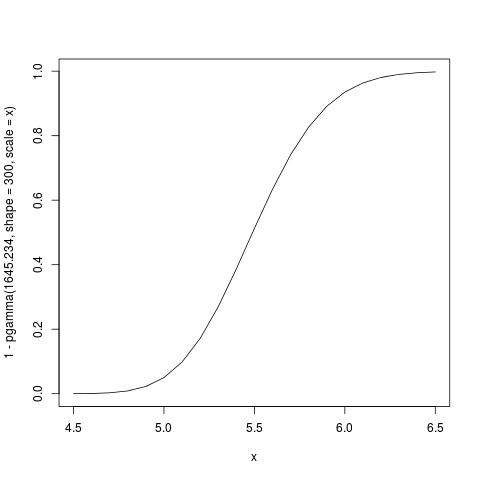

In [14]:
%%R
x <- seq(4.5,6.5, by = 0.1)
plot(x, 1 - pgamma(1645.234, shape = 300, scale = x), type = 'l')

In [15]:
%%R
minimize_this <- function(p){
    abs(0.8 - 1 + pgamma(1645.234, shape = 300, scale = p))
}
optimize(f = minimize_this, interval =c(5,6))

$minimum
[1] 5.765994

$objective
[1] 4.761707e-07

